In [1]:
from skimage.io import imread
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from random import shuffle

import os
import glob
from tqdm import tqdm

from util import load_positive_samples, load_negative_samples

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

%load_ext autoreload
%autoreload 2

In [2]:
def gray_scale(image):
    grey = np.mean(image, axis=2, keepdims=True)
    return grey

In [3]:
positive_samples = load_positive_samples()
negative_samples = load_negative_samples()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:16<00:00,  3.41it/s]


In [4]:
def plot_img(samples, select_num=6):   
    num_samples = len(samples)
    selected_index = np.random.choice(num_samples, select_num, replace=True)
    
    count = 0
    for index in selected_index:
        count += 1     
        plt_idx = count
        plt.subplot(1, select_num, plt_idx)
        plt.imshow(samples[index])
        plt.axis('off')
        
    plt.show()

15168


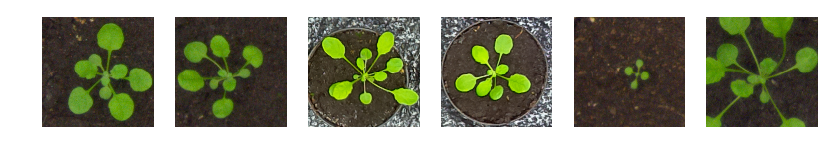

In [5]:
print(len(positive_samples))
plot_img(positive_samples)

19312


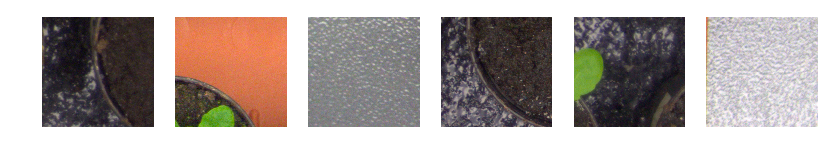

In [6]:
print(len(negative_samples))
plot_img(negative_samples)

In [7]:
from sklearn.model_selection import train_test_split

labels = []
fds = []
for sample in tqdm(positive_samples):
    sample = gray_scale(sample)
    sample = np.transpose(sample)
    fds.append(sample[:3,:,:])
    labels.append([1, 0])

shuffle(negative_samples)
for sample in tqdm(negative_samples):
    sample = gray_scale(sample)
    sample = np.transpose(sample)
    fds.append(sample[:3,:,:])
    labels.append([0, 1])

X_train, X_test, y_train, y_test = train_test_split(
    fds, labels, test_size=0.2, random_state=0)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19312/19312 [00:27<00:00, 698.39it/s]


In [8]:
from squeezenet import ConvNet_gray

# here you can switch between different CNN model
model, callback_list = ConvNet_gray (nb_classes=2)
hist = model.fit(np.array(X_train), np.array(y_train), batch_size=32, epochs=10, verbose=1, 
                callbacks=callback_list, validation_split=0.3, validation_data=None, 
                shuffle=True, initial_epoch=0)

Using TensorFlow backend.


conv model summary: 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 96, 112, 112)      4800      
_________________________________________________________________
conv2 (Conv2D)               (None, 96, 56, 56)        230496    
_________________________________________________________________
conv3 (Conv2D)               (None, 128, 28, 28)       110720    
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 128, 13, 13)       0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 13, 13)       0         
_________________________________________________________________
flatten (Flatten)            (None, 21632)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 

In [ ]:
from squeezenet import SqueezeNet, ConvNet
model, callback_list = SqueezeNet(nb_classes=2, is_testing=True)

In [9]:
model.evaluate(np.array(X_test), np.array(y_test), batch_size=32, verbose=1, sample_weight=None)

6896/6896 [==============================] - 23s    


[0.056034138011303136, 0.98723897911832947]

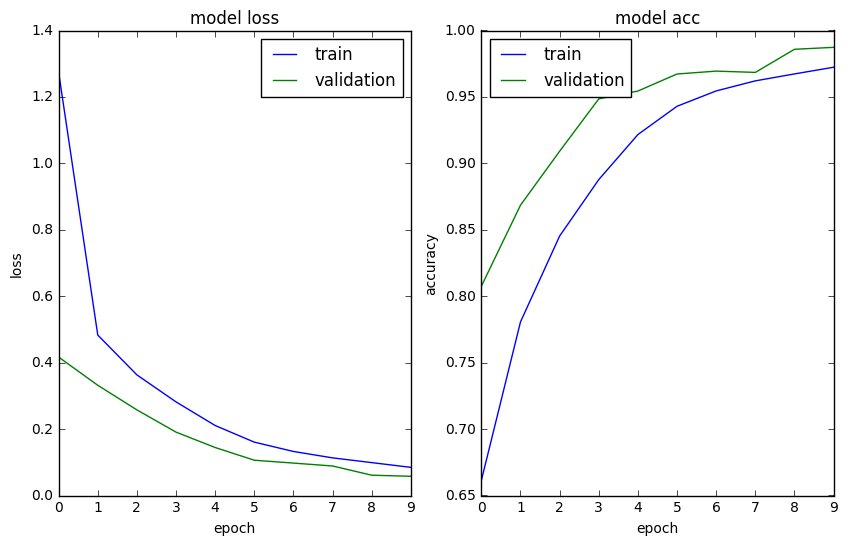

In [10]:
def plot(hist):
    '''
    plot training history accuracy and loss between training sets and validation sets
    '''
    plt.subplot(121)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')

    plt.subplot(122)
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('model acc')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
plot(hist)

In [11]:
pred = model.predict(np.array(X_test))

tp = 0
tn = 0
fp = 0
fn = 0

for i, score in enumerate(pred):
    if score[0] > score[1]:
        if y_test[i] == [1, 0]:
            tp += 1
        else:
            fp += 1
    
    else:
        if y_test[i] == [0, 1]:
            tn += 1
        else:
            fn += 1
    

print('precision: ', float(tp/(tp+fp)))
print('recall: ', float(tp/(tp+fn)))
print('f1: ', float(2*tp/(2*tp+fn+fp)))

precision:  0.9817567567567568
recall:  0.9884353741496599
f1:  0.9850847457627119


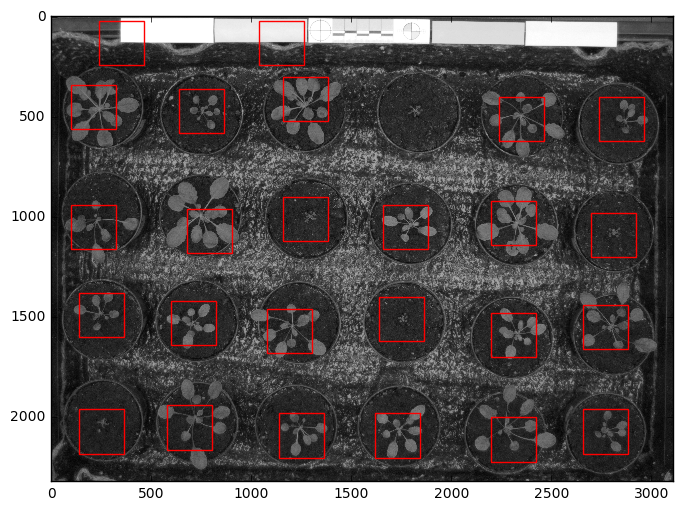

In [18]:
from util import nms
from util import sliding_window

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x[0]) / np.sum(np.exp(x))

min_window_size = (224, 224)
step_size = (20, 20)
confidence_threshold = 0.65
threshold = 0.02

detections = []

current_path = os.getcwd()
# img_path = os.path.join(current_path, 'Datasets', 'Tray', 'Ara2012', 'ara2012_tray01_rgb.png')
img_path = os.path.join(current_path, 'Datasets', 'Tray', 'Ara2013-Canon', 'ara2013_tray20_rgb.png')
im = imread(img_path)
im = gray_scale(im)

candidate_imgs = []
coordinates = []
for (x, y, im_window) in sliding_window(im, min_window_size, step_size):
        if im_window.shape[0] != min_window_size[0] or im_window.shape[1] != min_window_size[1]:
            continue
        candidate_imgs.append(np.transpose(im_window))
        coordinates.append([x, y])

candidate_imgs = np.array(candidate_imgs)
pred = model.predict(candidate_imgs)

for i, score in enumerate(pred):
    confidence = softmax(score)
    if confidence > confidence_threshold:
        detections.append((coordinates[i][0], coordinates[i][1], confidence,
            int(min_window_size[0]),
            int(min_window_size[1])))

# Display the results before performing NMS
clone = im.copy()

# Perform Non Maxima Suppression
left_detections = nms(detections, threshold)

# Create figure and axes
fig, ax = plt.subplots(1)

# Display the image
ax.imshow(np.squeeze(clone), cmap='gray')

# Display the results after performing NMS
for (x_tl, y_tl, _, w, h) in left_detections:
    # Draw the detections
    rect = patches.Rectangle((x_tl, y_tl), w, h, linewidth=1,edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    
plt.show()